In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
from clustering import *
from evaluation import *
from testing import time_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import random as rnd
import seaborn as sns

from tqdm.notebook import trange, tqdm

In [3]:
def pretty_plot(x, ys, ys_ids, font_size=16, fig_size=(10, 8), same_plot=True, x_label='', y_label='',
               title='',  ys_colors=None, culomns=1, x_labels=[], y_labels=[], multiple_curves=False, curve_labels=[]):
    """
    print multiple curves on a single plot or multiple subplots
    
    :param x: The x_axis points. if same_plot=False than it's should be a list of x_axis points.
    Each list is x_axis points for one subplot.
    :param ys: List in which each element is a list of y_axis points.
    :param ys_ids: :List of names for each plot. if same_plot=True than it will appear as legends else
    as a title to specific subplot.
    :param font_size: The font size of the title and legends. Default is 16.
    In subplots the recommended font size is 10.
    :param fig_size: Adjust the size of the plot or each subplot.
    
    
    :param same_plot: If True, we plot all the ys curves on a single plot. Else plot each element of
    (x,y) in zip(x,ys) as a different subplot. Default is True.
    :param x_label: Used only if same_plot=True and is the title of the x_axis.
    :param y_label: Used only if same_plot=True and is the title of the y_axis.
    :param title: Used only if same_plot=True. The plot title.
    :param ys_colors: Used only if same_plot=True. List of colors (e.g. 'b', 'r') for each curve.
    
    :param culomns: Used only if same_plot=False. The number of subplots in each row. Default to 1.
    Deafult to None, meaning choose automatic colors.
    :param x_labels: Used only if same_plot=False. List of names for each subplot x_axis.
    :param y_labels: Used only if same_plot=False. List of names for each subplot y_axis.
    :param multiple_curves: Used only if same_plot=False. If true, each subplot will have multiple curves
    else, each subplot will have a single curve. Default is False.
    :param curve_labels: Used only if same_plot=False and multiple_curves=True. Contaions labels for each curve in each subplot. 
    It's shape should be the same as ys shape. 
    """
    if same_plot:
        fig, ax = plt.subplots(1, 1, figsize=fig_size, )
        plt.rcParams['font.size'] = f'{font_size}'
        for i, (y, y_id) in enumerate(zip(ys, ys_ids)):
            if ys_colors is None:
                ax.plot(x, y, label=y_id, marker='*')
            else:
                ax.plot(x, y, label=y_id, color=ys_colors[i], marker='*')
            
        ax.set_xlabel(x_label, fontsize=font_size)
        ax.set_ylabel(y_label, fontsize=font_size)
        ax.grid()
        ax.legend()
        ax.set_title(title)
    else:
        rows = len(ys) // culomns + 1
        
        fig, ax = plt.subplots(rows, culomns, figsize=fig_size, )
        plt.rcParams['font.size'] = f'{font_size}'
        for i in range(rows):
            for j in range(culomns):
                index = i*culomns + j
                if index >= len(ys) :
                    ax[i,j].remove()
                    continue
                if multiple_curves:
                    for curve, curve_label in zip(ys[index],curve_labels[index]):
                        ax[i][j].plot(x[index], curve, label=curve_label, marker='*')
                    ax[i][j].legend()
                else:
                    ax[i][j].plot(x[index], ys[index])
                ax[i][j].set_xlabel(x_labels[index], fontsize=font_size)
                ax[i][j].set_ylabel(y_labels[index], fontsize=font_size)
                ax[i][j].set_title(ys_ids[index])
                ax[i][j].grid()
    fig.tight_layout()
    plt.show()

# simple test of pretty_plot

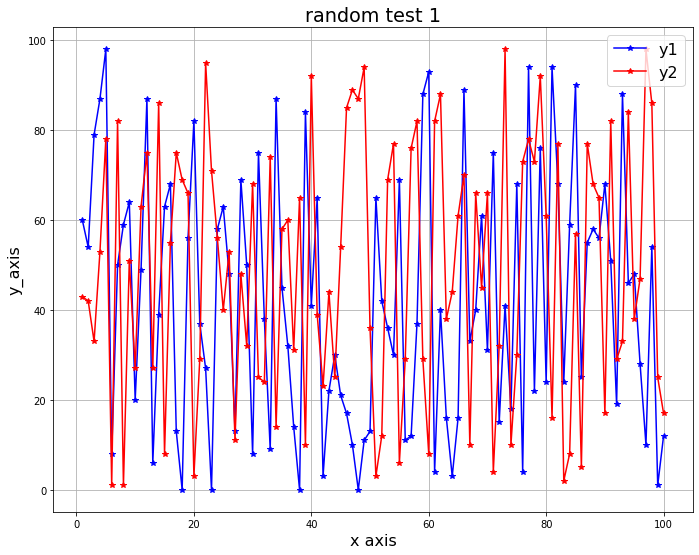

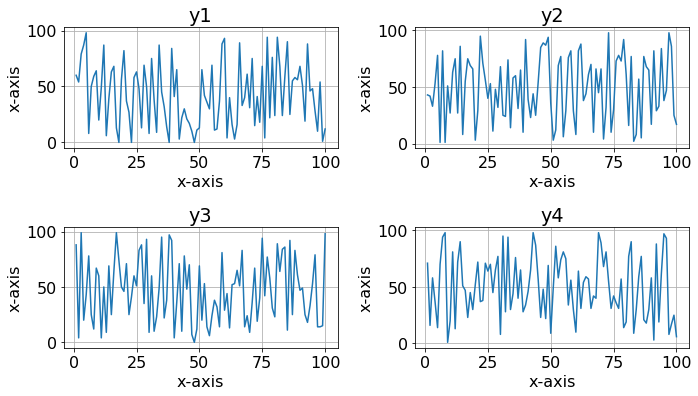

In [4]:
# simple test of pretty_plot
y1 = rnd.randint(100, size=100)
y2 = rnd.randint(100, size=100)
y3 = rnd.randint(100, size=100)
y4 = rnd.randint(100, size=100)
x = np.arange(1, 101)
pretty_plot(x,[y1,y2], ['y1', 'y2'] ,x_label='x axis', y_label='y_axis', ys_colors=['b', 'r'], title='random test 1')

pretty_plot([x,x,x,x],[y1,y2,y3,y4], ['y1', 'y2', 'y3', 'y4'], x_labels=['x-axis']*4, y_labels=['x-axis']*4,
           same_plot=False, culomns=2)


# constants initialization

In [6]:
# some constants
file_path = f"files/minion_idt/num_of_clusters strands in size read_len with error_val errors and "\
            f"cluster avg of 40/evyat files/evyat0file_num_index.txt"
algo_result_path = f"files/minion_idt/num_of_clusters strands in size read_len with error_val errors and "\
                   f"cluster avg of 40/algo_results/evyat0file_num_index_algo_result.txt"

error_val = 'x2'
read_len = 150
gammas = [0.9,0.93,0.95,0.98,0.99]
file_nums = [0, 1, 2, 3]
clusters_index_sizes = [(3000, 6), (6000, 7), (9000, 7), (15000, 7)]

# saving results in order to run the next cell ones

In [7]:
C_tils = {}
C_tils_union = {}
C_tils_singletons = {}

In [8]:
for (num_of_clusters, index_size) in tqdm(clusters_index_sizes):
    C_til_acc = {gamma: [] for gamma in gammas}
    C_til_union_acc = {gamma: [] for gamma in gammas}
    C_til_singletons_acc =  {gamma: [] for gamma in gammas}
    for file_num in tqdm(file_nums):
            
        curr_file_path = file_path.replace("file_num", f'{file_num}').\
        replace("num_of_clusters", f'{num_of_clusters}').\
        replace("read_len", f'{read_len}').\
        replace("error_val", f'{error_val}')

        curr_algo_result_path = algo_result_path.replace("file_num", f'{file_num}').\
        replace("num_of_clusters", f'{num_of_clusters}').\
        replace("read_len", f'{read_len}').\
        replace("error_val", f'{error_val}')
        
        cfg = (file_num, num_of_clusters, read_len, error_val)

        clustering_info = ClusteringInfo(file_path=curr_file_path)
        C_til, bin_sig_arr = file_to_algo_clustering(curr_algo_result_path)
        
        union_kwargs = dict(algo_clustering=copy.deepcopy(C_til), orig_cluster_info=clustering_info,
                            bin_sign_arr = bin_sig_arr, index_size=index_size)
        union_times, (C_til_union, unions_log) = time_function(handle_unions, **union_kwargs)
        
        singletons_kwargs = dict(algo_clustering=copy.deepcopy(C_til_union), 
                                 orig_cluster_info=clustering_info, 
                                 bin_sign_arr=bin_sig_arr, 
                                 index_size=index_size)
        singletons_times, (C_til_singletons, singletons_log) = time_function(handle_singletons_with_index_ver5_5, 
                                                                            **singletons_kwargs)
        
        C_tils[cfg] = (C_til, bin_sig_arr, clustering_info)
        C_tils_union[cfg] = (C_til_union, union_times, unions_log)
        C_tils_singletons[cfg] = (C_til_singletons, singletons_times, singletons_log)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

# computing accuracies for different gammas and for different number of clusters

In [9]:
# computing accuracies for different gammas and for different number of clusters
ys_acc, xs_acc, curve_labels_acc, ys_ids_acc, x_labels_acc, y_labels_acc = [], [], [], [], [], []

for (num_of_clusters, index_size) in tqdm(clusters_index_sizes):
    C_til_acc = {gamma: [] for gamma in gammas}
    C_til_union_acc = {gamma: [] for gamma in gammas}
    C_til_singletons_acc =  {gamma: [] for gamma in gammas}
    for file_num in tqdm(file_nums):
            
        cfg = (file_num, num_of_clusters, read_len, error_val)
        
        clustering_info = C_tils[cfg][2]
        C_til = C_tils[cfg][0]
        C_til_union = C_tils_union[cfg][0]
        C_til_singletons = C_tils_singletons[cfg][0]
        
        for gamma in gammas:
            C_til_acc[gamma].append(calc_acrcy(C_til, clustering_info.reads_err, clustering_info.C_dict, 
                             clustering_info.C_reps, gamma=gamma))
            C_til_union_acc[gamma].append(calc_acrcy(C_til_union, clustering_info.reads_err, clustering_info.C_dict, 
                                   clustering_info.C_reps, gamma=gamma))
            C_til_singletons_acc[gamma].append(calc_acrcy(C_til_singletons, clustering_info.reads_err, clustering_info.C_dict, 
                                   clustering_info.C_reps, gamma=gamma))
    
    avg_C_til_acc = [(sum(C_til_acc[gamma]) / len(C_til_acc[gamma])) for gamma in gammas]
    avg_C_til_union_acc = [(sum(C_til_union_acc[gamma]) / len(C_til_union_acc[gamma])) for gamma in gammas]
    avg_C_til_singletons_acc = [(sum(C_til_singletons_acc[gamma]) / len(C_til_singletons_acc[gamma])) for gamma in gammas]
    
    ys_acc.append([avg_C_til_acc, avg_C_til_union_acc, avg_C_til_singletons_acc])
    xs_acc.append(gammas)
    curve_labels_acc.append(['regular algo', 'after handling unions', 'after handling singletons'])
    ys_ids_acc.append(f"avg accuracies for different\n"\
                      fr"$\gamma 's$ with {num_of_clusters} clusters")
    x_labels_acc.append(r'$\gamma$')
    y_labels_acc.append(r'accuracy')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

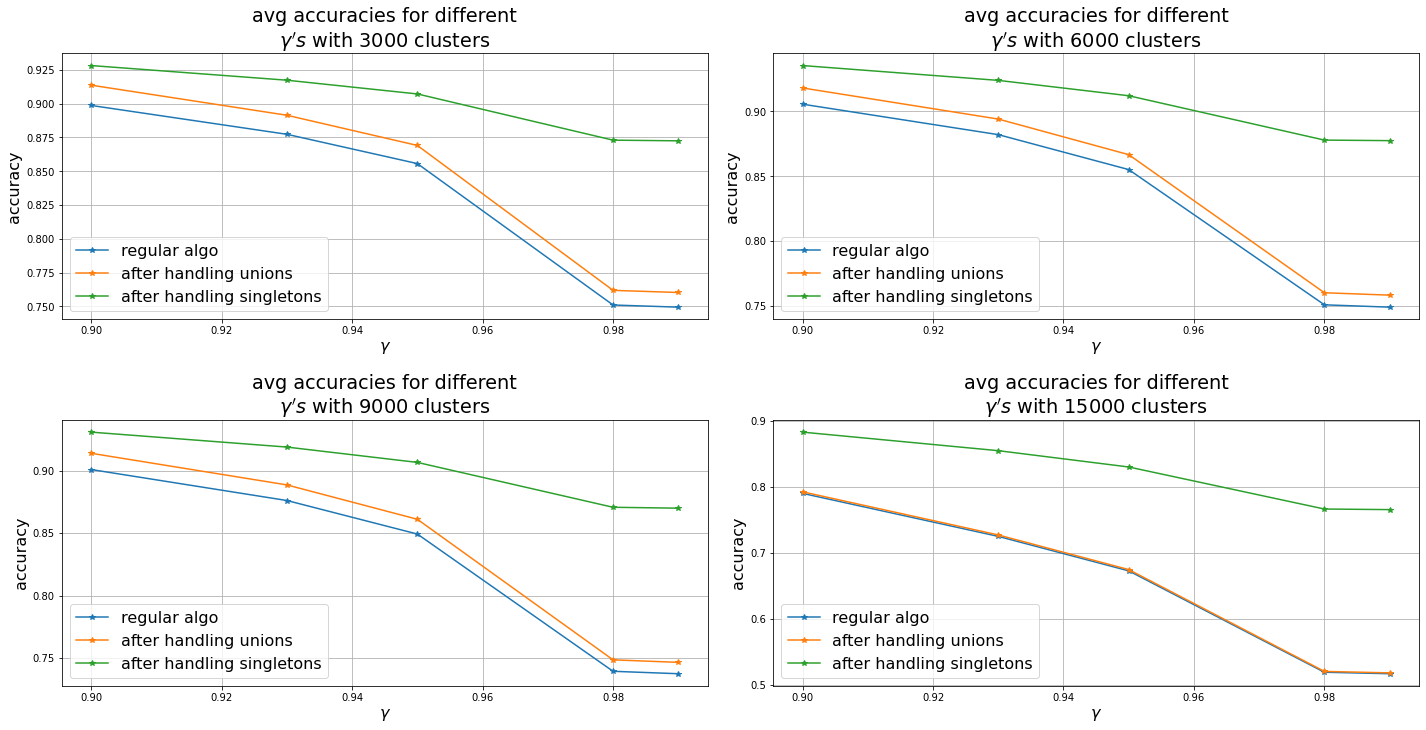

In [12]:
pretty_plot(xs_acc, ys_acc, ys_ids_acc, same_plot=False, culomns=2, multiple_curves=True, 
            curve_labels=curve_labels_acc, x_labels=x_labels_acc, y_labels=y_labels_acc, font_size=16, fig_size=(20,15))

# testing num_epoch parameter:

In [18]:
epochs = 10

In [48]:
ys_epochs, xs_epochs, curve_labels_epochs, ys_ids_epochs, x_labels_epochs, y_labels_epochs = [], [], [], [], [], []

# stats1, stats2 = find_clusters_stats(algo_clustering, orig_cluster_info)
# unwanted_singletons = find_unwanted_singletons(stats, gamma=0.5)
# def handle_singletons_with_index_ver5_5(algo_clustering, orig_cluster_info, bin_sign_arr, index_size,
#                                         threshold=10, num_epochs=2, num_of_hashes=20):

for file_num in tqdm(file_nums):
    xs, singletons, times = [], [], []
    for (num_of_clusters, index_size) in tqdm(clusters_index_sizes):
        
        cfg = (file_num, num_of_clusters, read_len, error_val)
        clustering_info = C_tils[cfg][2]
        C_til = C_tils[cfg][0]
        bin_sig_arr = C_tils[cfg][1]
        C_til_union = C_tils_union[cfg][0]
           
        singletons_kwargs = dict(algo_clustering=copy.deepcopy(C_til_union), 
                                 orig_cluster_info=clustering_info, 
                                 bin_sign_arr=bin_sig_arr, 
                                 index_size=index_size,
                                 num_epochs=epochs,
                                 return_stats=True)
        C_til_singletons, _, singltons_list, times_list = handle_singletons_with_index_ver5_5(**singletons_kwargs)
   
        singletons += [singltons_list]
        times += [times_list]
    xs = list(range(epochs+1))
    
    ys_epochs += [singletons, times]
    xs_epochs += [xs, xs]
    curve_labels_list = ['3000 clusters', '6000 clusters', '9000 clusters', '15000 clusters']
    curve_labels_epochs += [curve_labels_list, curve_labels_list]
    title1 = f"remaining singletons for different\n"\
             f"num of epochs in file 0{file_num}"
    title2 = f"time it took for different\n"\
             f"num of epochs in file 0{file_num}"
    ys_ids_epochs += [title1, title2]
    x_labels_epochs += ['epochs','epochs']
    y_labels_epochs += ['singletons','minutes']

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

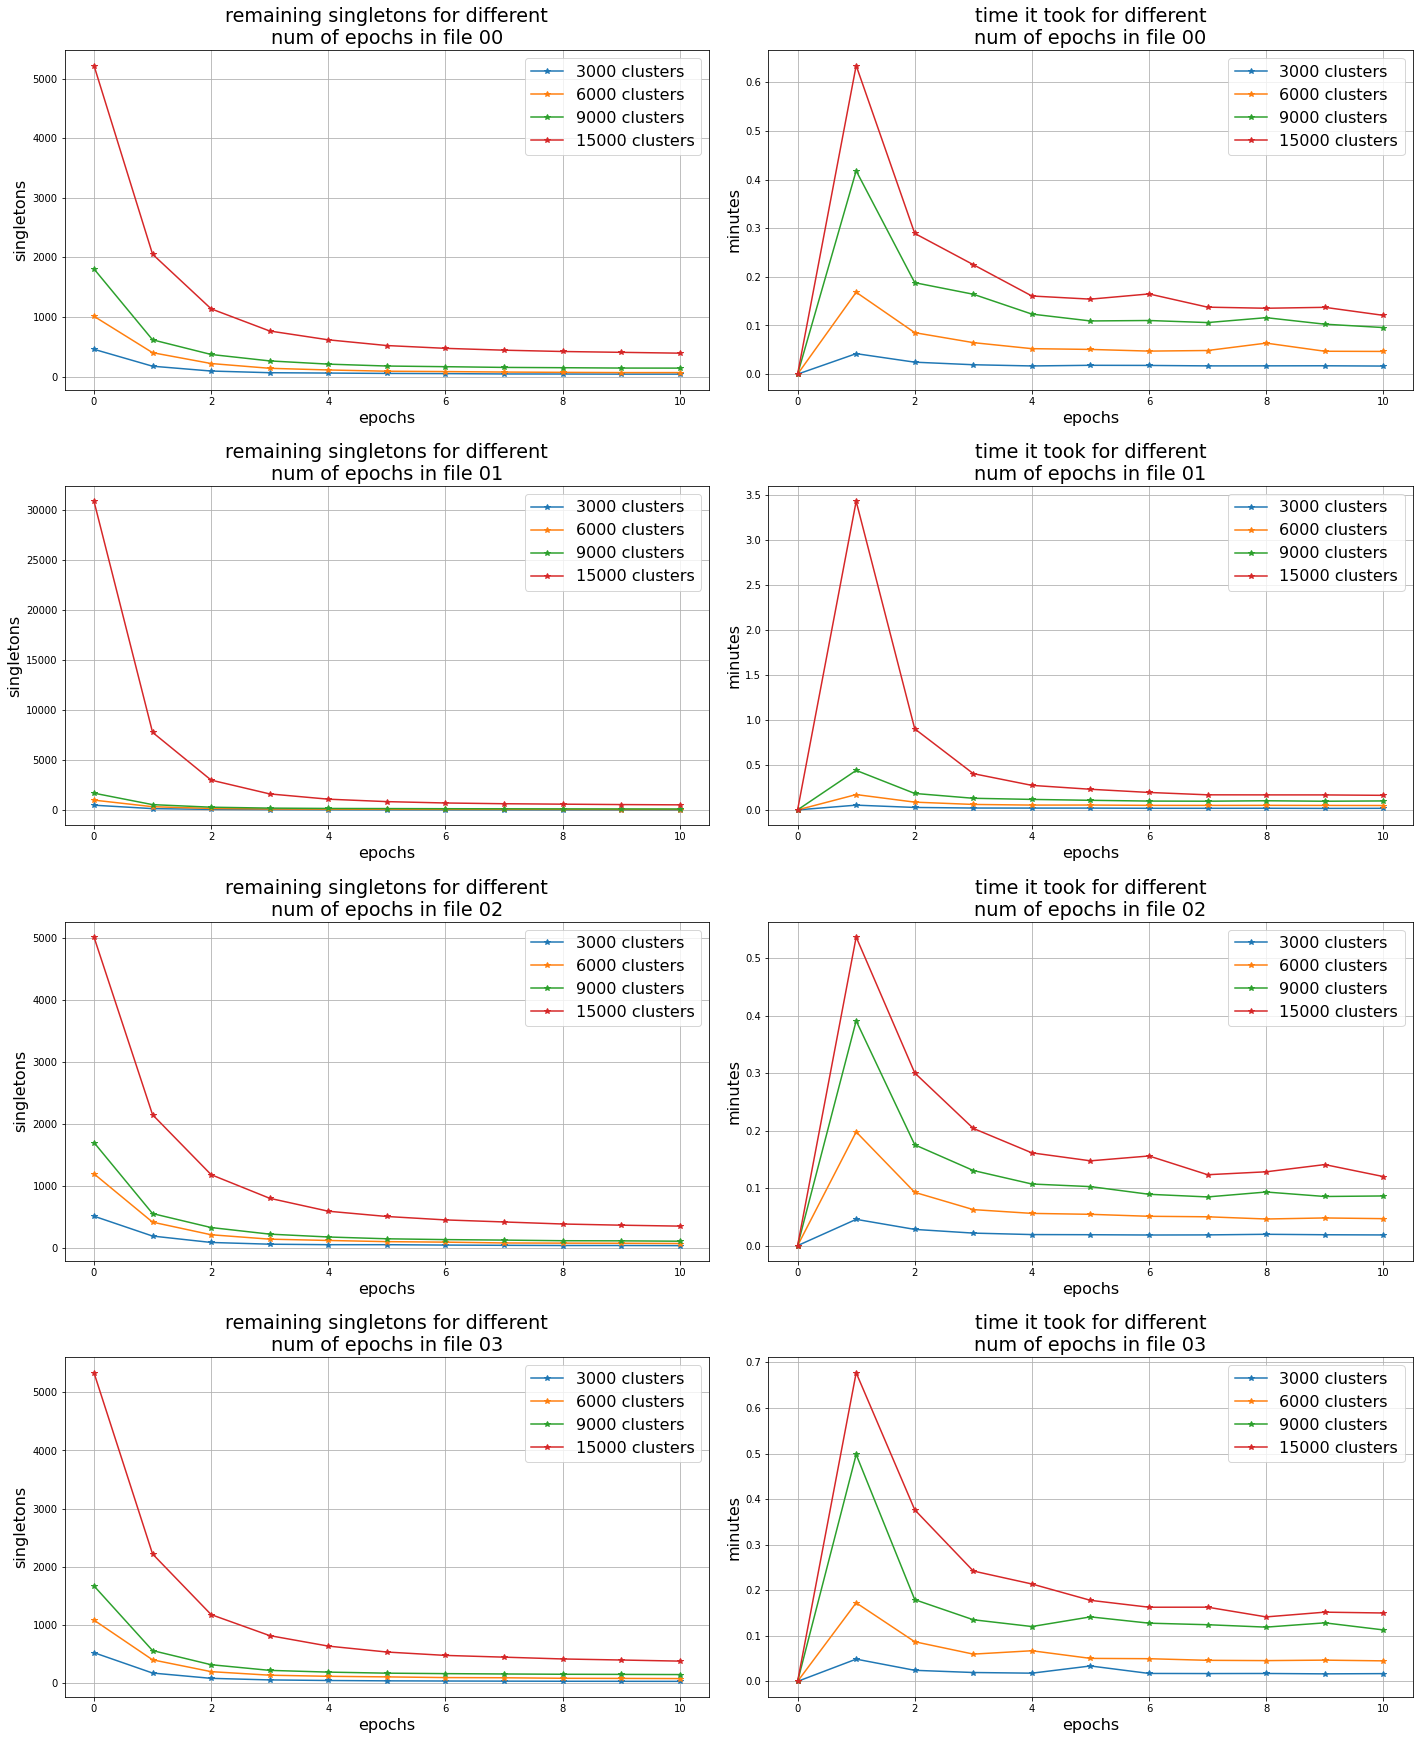

In [49]:
pretty_plot(xs_epochs, ys_epochs, ys_ids_epochs, same_plot=False, culomns=2, multiple_curves=True, 
            curve_labels=curve_labels_epochs, x_labels=x_labels_epochs, y_labels=y_labels_epochs, font_size=16, fig_size=(20,30))

# testing different (num_epochs, num_of_hashes) tuples

In [50]:
epochs = 10
hashes = [i for i in range(42) if i % 4 == 1]

In [76]:
rows_dict = {}
time_rows_dict = {}
for (num_of_clusters, index_size) in tqdm(clusters_index_sizes):
    rows = []
    time_rows = []
    for num_of_hashs in tqdm(hashes):
        cfg = (0, num_of_clusters, read_len, error_val)
        clustering_info = C_tils[cfg][2]
        C_til = C_tils[cfg][0]
        bin_sig_arr = C_tils[cfg][1]
        C_til_union = C_tils_union[cfg][0]

        singletons_kwargs = dict(algo_clustering=copy.deepcopy(C_til_union), 
                                 orig_cluster_info=clustering_info, 
                                 bin_sign_arr=bin_sig_arr, 
                                 index_size=index_size,
                                 num_epochs=epochs,
                                 num_of_hashes=num_of_hashs,
                                 return_stats=True)
        C_til_singletons, _, singltons_list, times_list = handle_singletons_with_index_ver5_5(**singletons_kwargs)
        rows.append(np.array(singltons_list[1:]))
        time_rows.append(np.array(times_list[1:]))
    rows_dict[num_of_clusters] = rows
    time_rows_dict[num_of_clusters] = time_rows

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

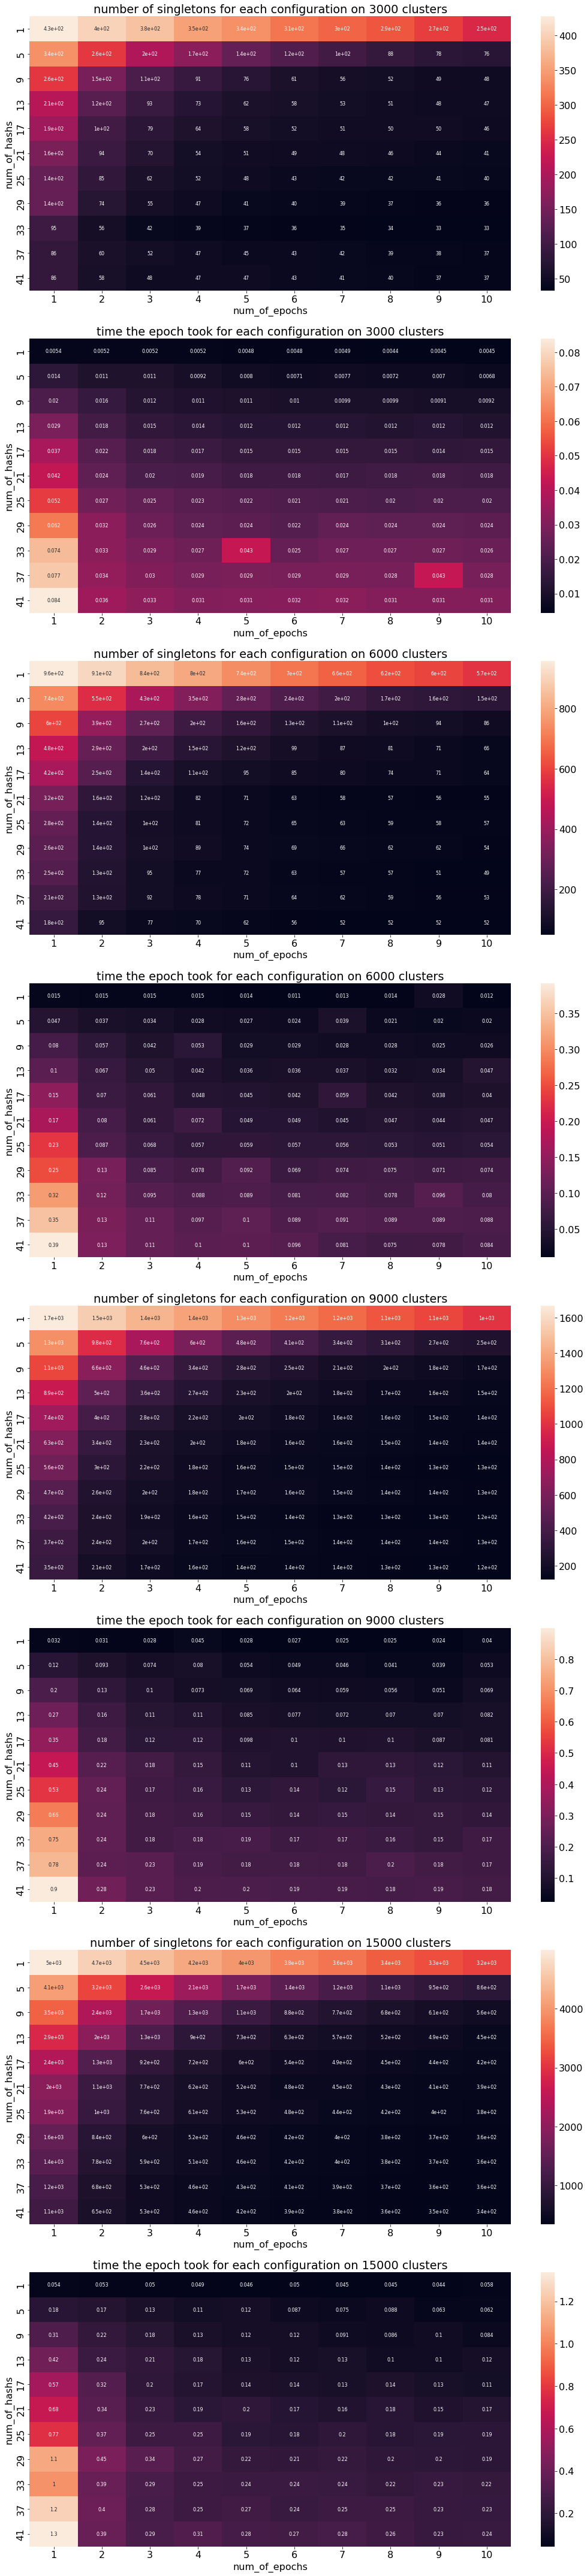

In [81]:
fig, axs = plt.subplots(8, 1, figsize=(15,15*4))
xticklabels = list(range(1, epochs+1))
yticklabels = hashes

for i, (num_of_clusters, index_size) in enumerate(clusters_index_sizes):
    singletons_mat = np.stack(rows_dict[num_of_clusters])
    time_mat = np.stack(time_rows_dict[num_of_clusters])

    sns.heatmap(singletons_mat, xticklabels=xticklabels, yticklabels=yticklabels, annot=True, annot_kws={'size': 8}, ax=axs[2*i])
    axs[2*i].set_xlabel('num_of_epochs', fontsize=16)
    axs[2*i].set_ylabel('num_of_hashs', fontsize=16)
    axs[2*i].set_title(f'number of singletons for each configuration on {num_of_clusters} clusters')

    sns.heatmap(time_mat, xticklabels=xticklabels, yticklabels=yticklabels, annot=True, annot_kws={'size': 8}, ax=axs[2*i+1])
    axs[2*i+1].set_xlabel('num_of_epochs', fontsize=16)
    axs[2*i+1].set_ylabel('num_of_hashs', fontsize=16)
    axs[2*i+1].set_title(f'time the epoch took for each configuration on {num_of_clusters} clusters')

fig.tight_layout()
plt.show()